In [0]:
import torch
from torch import nn
from torch.nn import init 
from torch.nn.parameter import Parameter
from torch.autograd import Function
import math
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
# ------------
from collections import Counter
from torch.autograd import Variable
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from collections import Counter
import argparse
import torch
import torch.nn as nn
import numpy as np

from torch.utils.data import Dataset
from torch.nn.utils import clip_grad_norm_
from tqdm import tqdm_notebook as tqdm
from torch.nn import functional as F

import warnings
warnings.filterwarnings("ignore")

import json
import time

import sys
sys.argv=['']
del sys

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook as tqdm

%matplotlib inline

## Shapley Activation (SA)

In [0]:
class SA(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(SA, self).__init__()
        self.weight = Parameter(torch.Tensor(out_features, in_features))
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters() 

    @staticmethod   
    def calculate_linear(wx, bias):
      output = wx.sum(1) + bias
      return output

    @staticmethod   
    def calculate_norm(wx, bias):
        norm = torch.distributions.Normal(0, 1)
        
        sigma = wx.pow(2).sum(1) / 6 + wx.sum(1).pow(2) / 12
        mu = wx.sum(1) / 2
        
        phi = norm.cdf((mu + bias) / sigma**0.5)
        return phi

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)
                                       
    def forward(self, input):
        #wx:[bs, in_features, out_features]
        #wx = input.unsqueeze(-1).mul(self.weight.t())
        wx = input.view(-1,self.weight.shape[1],1).mul(self.weight.t())
        norm_ = self.calculate_norm(wx, self.bias.t())
        linear_ = self.calculate_linear(wx, self.bias.t())
        return norm_.mul(linear_) 
        
    

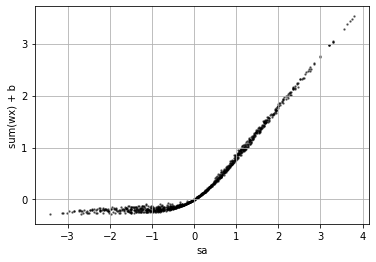

In [4]:
wx = torch.FloatTensor(1000, 5).uniform_(-1, 1)
b = torch.tensor(0, dtype=torch.float)


y_norm = SA.calculate_norm(wx, b)
y_linear = SA.calculate_linear(wx, b)
y_sa = y_norm.mul(y_linear).data.numpy()
plt.scatter(y_linear.data.numpy(), y_sa, s = 2, c='black', alpha=0.5)
plt.xlabel('sa')
plt.ylabel('sum(wx) + b')

plt.yticks([0, 1, 2, 3])
plt.grid()

## ShapLU

In [0]:
class ShapleyFunction(Function):
    @staticmethod
    def forward(ctx, input, weight, bias=None):
        ctx.save_for_backward(input, weight, bias)
        #output = input.mm(weight.t())
        output = input.view(-1,weight.shape[1]).mm(weight.t())
        if bias is not None:
            output += bias.unsqueeze(0).expand_as(output)
        return torch.max(output, torch.zeros_like(output))
    
    @staticmethod
    def backward(ctx, grad_output):
        input, weight, bias = ctx.saved_tensors
        grad_input = grad_weight = grad_bias = None
        
        norm_distr = torch.distributions.Normal(0, 1)
        #wx = input.unsqueeze(-1).mul(weight.t())
        wx = input.view(-1,weight.shape[1],1).mul(weight.t())
        
        mu = wx.sum(1) / 2
        sigma = (wx.pow(2).sum(1) / 6 + wx.sum(1).pow(2) / 12).pow(0.5)
        
        param = (bias+mu) / sigma
        phi_cdf = norm_distr.cdf(param)
        
        if ctx.needs_input_grad[0]:
            grad_input = (phi_cdf*grad_output).mm(weight)
            
        if ctx.needs_input_grad[1]:
            grad_weight = (phi_cdf*grad_output).t().mm(input)
            
        if bias is not None and ctx.needs_input_grad[2]:
            n = weight.size(-1)
            phi = torch.exp(norm_distr.log_prob(param)) / sigma
            g = (wx + bias / n).sum(1)
            grad_bias = (grad_output*(phi_cdf + phi*g)).sum(0)

        return grad_input, grad_weight, grad_bias

In [0]:
class ShapLU(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = Parameter(torch.Tensor(out_features, in_features))
        k = (1 / in_features)**0.5
        nn.init.uniform_(self.weight, -k, k)
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
            nn.init.uniform_(self.bias, -k, k)
        else:
            self.register_parameter('bias', None)
    
    def forward(self, input):
        return ShapleyFunction.apply(input, self.weight, self.bias)

## Эксперементы

In [7]:
cuda = torch.device('cuda')
torch.cuda.is_available()

True

### MNIST

In [8]:
download_path = './MNIST/'
mnist_train = datasets.MNIST(download_path, train=True, download=True, transform=transforms.ToTensor())
mnist_val = datasets.MNIST(download_path, train=False, download=True, transform=transforms.ToTensor())


0it [00:00, ?it/s]

9920512it [00:01, 8728264.25it/s]                            


Extracting ./MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 142203.63it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw


1654784it [00:00, 2576869.71it/s]                           
0it [00:00, ?it/s]

Extracting ./MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/MNIST/raw


8192it [00:00, 54455.25it/s]            

Extracting ./MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/MNIST/raw
Processing...
Done!


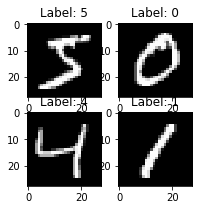

In [9]:
plt.figure(figsize=[3, 3])
for i in range(4):
    plt.subplot(2, 2, i + 1)
    # get img and label from mnist_train    
    img, label = mnist_train[i]

    plt.title("Label: {}".format(label))
    plt.imshow(img[0], cmap='gray')

In [0]:
mnist_train = [mnist_train[i] for i in torch.randint(0, 60000, (10000,))]

In [0]:
batch_size = 100
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mnist_val, batch_size=batch_size, shuffle=True)

In [0]:
def train(model, optimizer, iterator):
    model.train()
    log = {'loss': [], 'acc': [], 'step': []}
    for x, y in iterator:
        x, y = x.cuda(), y.cuda()
        x = x.view(x.shape[0], -1)
        optimizer.zero_grad()
        output = model(x)
        pred = torch.argmax(output, dim=-1)

        acc = torch.mean((pred == y).data.float()).item()
        loss = F.cross_entropy(output, y)

        loss.backward()
        optimizer.step()

        log['loss'].append(loss.item())
        log['acc'].append(acc)

    return log
        
def test(model, iterator):
    model.eval()
    log = {'acc': []}
    
    for x, y in iterator:
        x, y = x.cuda(), y.cuda()
        bs = x.shape[0]
        x = x.view(bs, -1)
        output = model(x)
        pred = torch.argmax(output, dim=-1)

        acc = torch.mean((pred == y).data.float()).item()
        log['acc'].append(acc)

    return log

In [0]:
class ShapLUModel(nn.Module):
    '''
      Shapley activation for Mnist
    '''
    def __init__(self, D_in, D_out):
        super(ShapLUModel, self).__init__()
        self.linear1 = ShapLU(D_in, 100)
        self.linear2 = ShapLU(100, 50)
        self.head = nn.Linear(50, D_out)


    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.head(x)
        return F.softmax(x, dim=-1)

In [0]:
class SAModel(nn.Module):
    '''
      Shapley activation for Mnist
    '''
    def __init__(self, D_in, D_out):
        super(SAModel, self).__init__()
        self.linear1 = SA(D_in, 100)
        self.linear2 = SA(100, 50)
        self.head = nn.Linear(50, 10)


    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.head(x)
        return F.softmax(x, dim=-1)

In [0]:
class ReLUModel(nn.Module):
    def __init__(self, D_in, D_out):
        super(ReLUModel, self).__init__()
        self.linear1 = nn.Linear(D_in, 100)
        self.linear2 = nn.Linear(100, 50)
        self.head = nn.Linear(50, D_out)

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.head(x)
        return F.softmax(x, dim=-1)

In [0]:
def run_experiments(model_obj, opt_obj, opt_params, iterator, in_dim, out_dim, num_exper, num_epoch):
    n = len(iterator)
    loss_logs = np.empty((num_exper, n*num_epoch))
    acc_logs = np.empty((num_exper, n*num_epoch))

    for i in tqdm(range(num_exper)):
        model = model_obj(in_dim, out_dim).cuda()
        optimizer = opt_obj(model.parameters(), **opt_params)

        for epoch in range(4):
            log = train(model, optimizer, iterator)
            loss_logs[i, n*epoch:n*(epoch+1)] = np.array(log['loss'])
            acc_logs[i, n*epoch:n*(epoch+1)] = np.array(log['acc'])

    return loss_logs, acc_logs, model
        

In [17]:
in_dim = np.prod(mnist_train[0][0].shape)
out_dim = 10
shaplu_loss, shaplu_acc, model_shaplu = run_experiments(ShapLUModel, torch.optim.Adam, {'lr': 0.001, 'betas': (0.9, 0.999)}, train_loader, in_dim, out_dim, 20, 4)
sa_loss, sa_acc, model_sa = run_experiments(SAModel, torch.optim.Adam, {'lr': 0.001, 'betas': (0.9, 0.999)}, train_loader, in_dim, out_dim, 20, 4)
relu_loss, relu_acc, model_relu = run_experiments(ReLUModel, torch.optim.Adam, {'lr': 0.001, 'betas': (0.9, 0.999)}, train_loader, in_dim, out_dim, 20, 4)

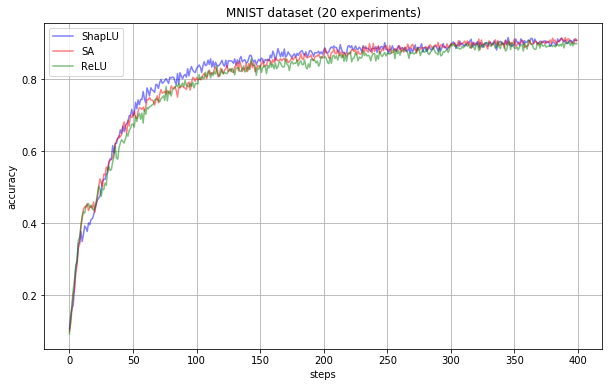

In [18]:
plt.figure(figsize=(10,6))
for log_acc, label, color in zip([shaplu_acc, sa_acc, relu_acc], ['ShapLU','SA','ReLU'], ['blue','red','green']):
    steps = np.arange(log_acc.shape[1])
    acc_mean = np.mean(log_acc, axis=0)
    plt.plot(steps, acc_mean, label=label, color=color, alpha=0.5)
plt.title('MNIST dataset (20 experiments)')
plt.xlabel('steps')
plt.ylabel('accuracy')
plt.legend()
plt.grid();

In [19]:
log_test_sa = test(model_sa, val_loader)
log_test_shaplu = test(model_shaplu, val_loader)
log_test_relu = test(model_relu, val_loader)

print('Test accuracy\nShapley activation: {:.3f}\nShapLU: {:.3f}\nReLU: {:.3f}'.format(np.mean(log_test_sa['acc']),
                                                                                       np.mean(log_test_shaplu['acc']),
                                                                                       np.mean(log_test_relu['acc'])))

Test accuracy
Shapley activation: 0.916
ShapLU: 0.897
ReLU: 0.914


### CIFAR

In [0]:
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader
import numpy as np

In [0]:
download_path = './CIFAR10/'
cifar_train = datasets.CIFAR10(download_path, train=True, download=True, transform=transforms.ToTensor())
cifar_val = datasets.CIFAR10(download_path, train=False, download=True, transform=transforms.ToTensor())

In [0]:
batch_size=100
train_loader = DataLoader(cifar_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(cifar_val, batch_size=batch_size, shuffle=False)

В статье используется полносвязная сетка с 3мя скрытыми слоями размерностью 1024, 512, 512. И запускается 200 эпох. Это долго. В нашем эксперементе мы упростили сетку до 2х скрытых слоев размером 100 и запускаем только 100 эпох

In [0]:
class RelUModelCIFAR(nn.Module):
    def __init__(self, D_in, D_out):
        super(RelUModelCIFAR, self).__init__()
        self.linear1 = nn.Linear(D_in, 100)
        self.linear2 = nn.Linear(100, 100)
        self.fc = nn.Linear(100, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.fc(x)
        return F.log_softmax(x, dim=-1)

In [0]:
criterion = nn.CrossEntropyLoss()

In [0]:
def train(model, optimizer, iterator):
    global train_step
    model.train()
    log = []

    for x, y in tqdm(iterator):
        x, y = x.cuda(), y.cuda()
        bs = x.shape[0]
        x = x.reshape(bs, -1)

        optimizer.zero_grad()
        output = model(x)
        pred = torch.argmax(output, dim=-1)

        acc = torch.mean((pred == y).data.float()).item()
        loss = criterion(output, y)

        loss.backward()
        optimizer.step()

        log.append(dict(
            train_loss=loss.item(),
            train_acc=acc,
            train_step=train_step,
        ))
        train_step += 1
        if train_step % 500 == 0:
          print('train step', train_step)

    epoch_accuracy = np.mean([x['train_acc'] for x in log])
    return epoch_accuracy

def test(model, optimizer, iterator):
    model.eval()
    log = []

    for x, y in tqdm(iterator):
        x, y = x.cuda(), y.cuda()
        bs = x.shape[0]
        x = x.reshape(bs, -1)

        output = model(x)
        pred = torch.argmax(output, dim=-1)

        acc = torch.mean((pred == y).data.float()).item()

        log.append(dict(
            train_acc=acc,
            train_step=train_step,
        ))

    epoch_accuracy = np.mean([x['train_acc'] for x in log])
    return epoch_accuracy

In [0]:
model_lin = RelUModelCIFAR(np.prod(cifar_train[0][0].shape), 10).cuda()
opt = torch.optim.Adam(model_lin.parameters(), lr=0.001, betas=(0.9, 0.999))

In [0]:
epoch_log_relu = []
train_step = 0

for epoch in range(100):
    epoch_log_relu.append(train(model_lin, opt, train_loader))


In [0]:
class SAModelCIFAR(nn.Module):
    def __init__(self, D_in, D_out):
        super(SAModelCIFAR, self).__init__()
        self.linear1 = SA(D_in, 100)
        self.linear2 = SA(100, 100)
        self.fc = SA(100, D_out)

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=-1)

In [0]:
model_sa = SAModelCIFAR(np.prod(cifar_train[0][0].shape), 10).cuda()
opt = torch.optim.Adam(model_sa.parameters(), lr=0.001, betas=(0.9, 0.999))

epoch_log_sa = []
train_step = 0

for epoch in range(100):
    epoch_log_sa.append(train(model_sa, opt, train_loader))

In [0]:
plt.plot(epoch_log_sa, label='SA', alpha=0.4)
plt.plot(epoch_log, label='ReLU', alpha=0.4)
plt.legend()
plt.xlabel('epoch')
plt.grid()

In [0]:
accuracy_test_sa = test(model_sa, opt, val_loader)
accuracy_test_relu = test(model_lin, opt, val_loader)

print('Test accuracy\nSapley activation: {:.3f}\nReLU: {:.3f}'.format(np.mean(accuracy_test_sa), np.mean(accuracy_test_relu)))

## Shapley interpreteation

In [21]:
!pip install shap

     |████████████████████████████████| 266kB 4.9MB/s 
  Created wheel for shap: filename=shap-0.32.1-cp36-cp36m-linux_x86_64.whl size=376820 sha256=5bf7033fe6b488c14af875921c676b4623d1e6122285870bbe5ae5733a8399e7
  Stored in directory: /root/.cache/pip/wheels/8e/b2/50/8fadb5a59789cb5bdeb01b800223be540651ae92915172050b
Successfully built shap


In [0]:
import shap
import warnings
warnings.filterwarnings("ignore")

In [0]:
batch_size = 1500
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(mnist_val, batch_size=batch_size, shuffle=True)

In [24]:
# since shuffle=True, this is a random sample of test data
batch = next(iter(val_loader))
images, labels = batch

dig_ind = [np.where(labels == i)[0][10] for i in range(10)]
mask_array = np.zeros_like(labels.numpy(), dtype=int)
mask_array[dig_ind] = 1
mask = mask_array == 1

images = images.cuda()

background = images[~mask]

dig_order = np.argsort(dig_ind)
images_m = images[mask]
images_tmp = np.zeros_like(images_m.cpu())
for i, j in enumerate(dig_order):
  images_tmp[j] = images_m[i][:,np.newaxis,:,:].cpu()
test_images =  torch.from_numpy(images_tmp)

e_shaplu = shap.DeepExplainer(model_shaplu, background)
e_sa = shap.DeepExplainer(model_sa, background)
e_relu = shap.DeepExplainer(model_relu, background)

shap_values_shaplu = e_shaplu.shap_values(test_images)
shap_values_sa = e_sa.shap_values(test_images)
shap_values_relu = e_relu.shap_values(test_images)


In [0]:
shap_numpy_shaplu_1 = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values_shaplu]
test_numpy_shaplu = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
shap_numpy_shaplu = shap_numpy_shaplu_1

shap_numpy_sa_1 = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values_sa]
test_numpy_sa = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
shap_numpy_sa = shap_numpy_sa_1

shap_numpy_relu_1 = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values_relu]
test_numpy_relu = np.swapaxes(np.swapaxes(test_images.cpu().numpy(), 1, -1), 1, 2)
shap_numpy_relu = shap_numpy_relu_1

In [0]:
# plot the feature attributions
# print("ReLu")
# shap.image_plot(shap_numpy_relu, -test_numpy_relu)

# # plot the feature attributions
# print("SHAPLu")
# shap.image_plot(shap_numpy_shaplu, -test_numpy_shaplu)

# # plot the feature attributions
# print("SA")
# shap.image_plot(shap_numpy_sa, -test_numpy_sa)

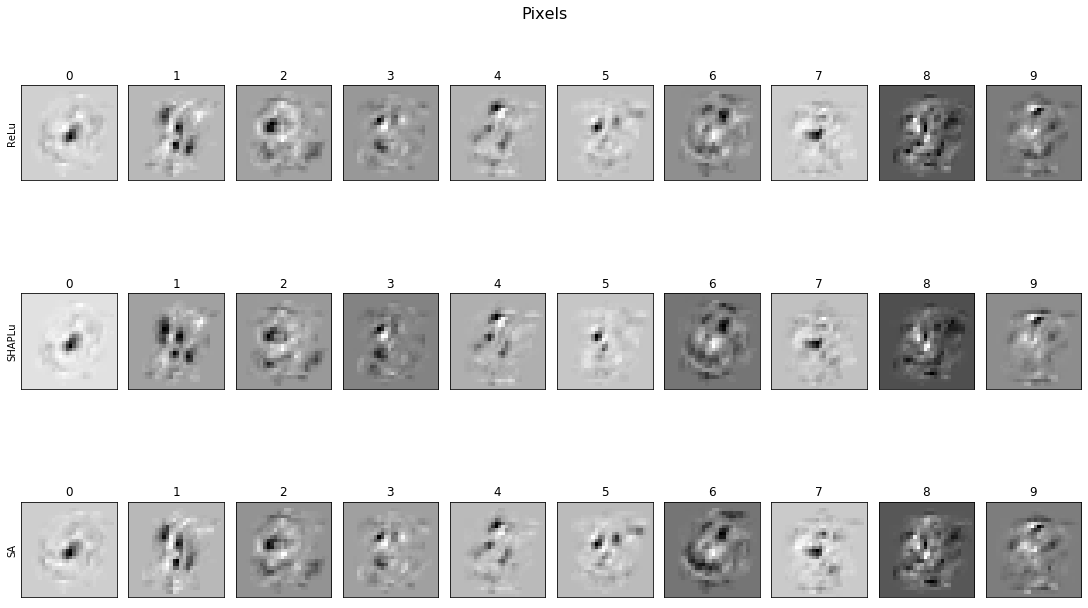

In [27]:
fig, axs = plt.subplots(3, 10, figsize=[15, 9], constrained_layout=True)
fig.suptitle('Pixels', fontsize=16)

axs[0,0].set_ylabel('ReLu')
axs[1,0].set_ylabel('SHAPLu')
axs[2,0].set_ylabel('SA')
for i in range(10):
    results_relu = np.sum(shap_numpy_relu_1[i][:], axis = 0).copy()
    results_shaplu = np.sum(shap_numpy_shaplu_1[i][:], axis = 0).copy()
    results_sa = np.sum(shap_numpy_sa_1[i][:], axis = 0).copy()
    #results[results < 0] = 0
    axs[0,i].set_title("%i" % i)
    axs[0,i].imshow(results_relu.reshape([28, 28]), cmap='gray')
    axs[1,i].set_title("%i" % i)
    axs[1,i].imshow(results_shaplu.reshape([28, 28]), cmap='gray')
    axs[2,i].set_title("%i" % i)
    axs[2,i].imshow(results_sa.reshape([28, 28]), cmap='gray')

    axs[0,i].set_xticks([], [])
    axs[0,i].set_yticks([], []) 
    axs[1,i].set_xticks([], [])
    axs[1,i].set_yticks([], []) 
    axs[2,i].set_xticks([], [])
    axs[2,i].set_yticks([], []) 

plt.show()

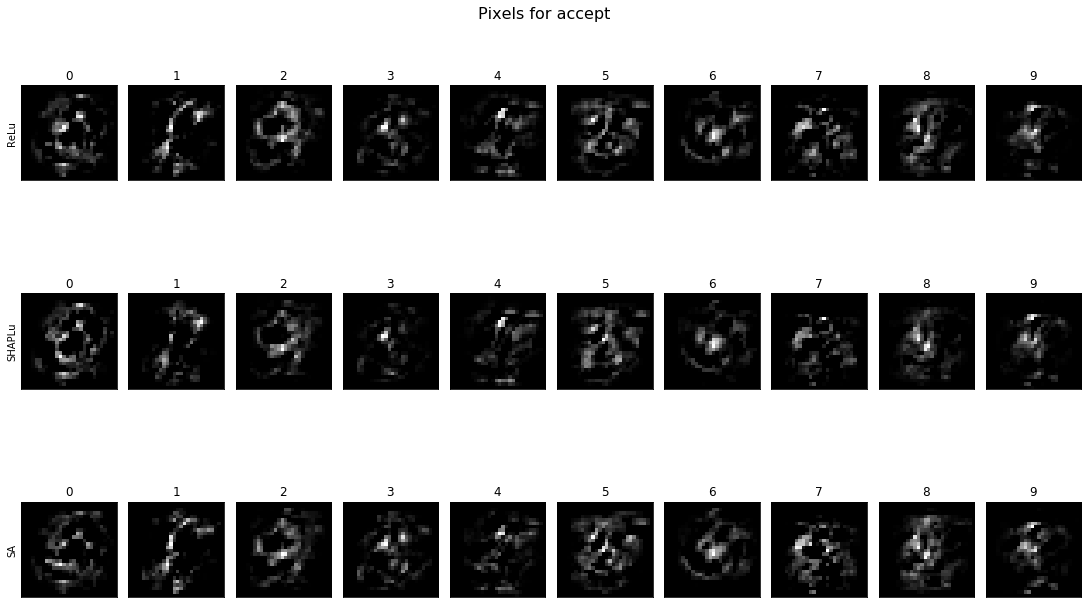

In [28]:
fig, axs = plt.subplots(3, 10, figsize=[15, 9], constrained_layout=True)
fig.suptitle('Pixels for accept', fontsize=16)

axs[0,0].set_ylabel('ReLu')
axs[1,0].set_ylabel('SHAPLu')
axs[2,0].set_ylabel('SA')
for i in range(10):
    results_relu = np.sum(shap_numpy_relu[i][:], axis = 0).copy()
    results_relu[results_relu < 0] = results_relu[0][0]
    results_shaplu = np.sum(shap_numpy_shaplu[i][:], axis = 0).copy()
    results_shaplu[results_shaplu < 0] = results_shaplu[0][0]
    results_sa = np.sum(shap_numpy_sa[i][:], axis = 0).copy()
    results_sa[results_sa < 0] = results_sa[0][0]
    #
    axs[0,i].set_title("%i" % i)
    axs[0,i].imshow(results_relu.reshape([28, 28]), cmap='gray')
    axs[1,i].set_title("%i" % i)
    axs[1,i].imshow(results_shaplu.reshape([28, 28]), cmap='gray')
    axs[2,i].set_title("%i" % i)
    axs[2,i].imshow(results_sa.reshape([28, 28]), cmap='gray')

    axs[0,i].set_xticks([], [])
    axs[0,i].set_yticks([], []) 
    axs[1,i].set_xticks([], [])
    axs[1,i].set_yticks([], []) 
    axs[2,i].set_xticks([], [])
    axs[2,i].set_yticks([], []) 

plt.show()


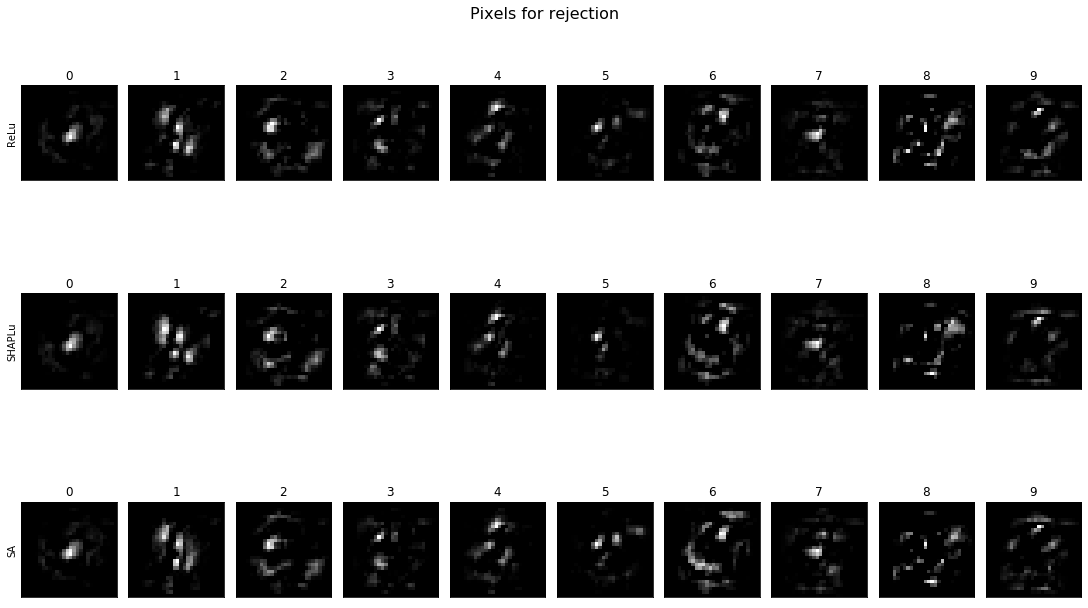

In [29]:
fig, axs = plt.subplots(3, 10, figsize=[15, 9], constrained_layout=True)
fig.suptitle('Pixels for rejection', fontsize=16)

axs[0,0].set_ylabel('ReLu')
axs[1,0].set_ylabel('SHAPLu')
axs[2,0].set_ylabel('SA')
for i in range(10):
    results_relu = -1 * np.sum(shap_numpy_relu[i][:], axis = 0).copy()
    results_relu[results_relu < 0] = results_relu[0][0]
    results_shaplu = -1 * np.sum(shap_numpy_shaplu[i][:], axis = 0).copy()
    results_shaplu[results_shaplu < 0] = results_shaplu[0][0]
    results_sa = -1 * np.sum(shap_numpy_sa[i][:], axis = 0).copy()
    results_sa[results_sa < 0] = results_sa[0][0]
    #
    axs[0,i].set_title("%i" % i)
    axs[0,i].imshow(results_relu.reshape([28, 28]), cmap='gray')
    axs[1,i].set_title("%i" % i)
    axs[1,i].imshow(results_shaplu.reshape([28, 28]), cmap='gray')
    axs[2,i].set_title("%i" % i)
    axs[2,i].imshow(results_sa.reshape([28, 28]), cmap='gray')

    axs[0,i].set_xticks([], [])
    axs[0,i].set_yticks([], []) 
    axs[1,i].set_xticks([], [])
    axs[1,i].set_yticks([], []) 
    axs[2,i].set_xticks([], [])
    axs[2,i].set_yticks([], []) 

plt.show()


# RNN

Обработка датасата 20newsgroup на pytorch

1. https://github.com/dmesquita/understanding_pytorch_nn
2. https://blog.floydhub.com/long-short-term-memory-from-zero-to-hero-with-pytorch/
3. https://www.analyticsvidhya.com/blog/2018/11/tutorial-text-classification-ulmfit-fastai-library/
4. https://pastebin.com/wx3pcArQ
5. https://github.com/mireshghallah/20Newsgroups-Pytorch/blob/master/newsgroup-pytorch-git.ipynb
6. https://www.kaggle.com/crawford/20-newsgroups/kernels


Реализация RNN:

1. https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html#creating-the-network

In [30]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

print('total texts in train:', len(newsgroups_train.data))
print('total texts in test:', len(newsgroups_test.data))

total texts in train: 11314
total texts in test: 7532


In [31]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from string import punctuation
import nltk
nltk.download('popular')

exclude = set(punctuation + '0123456789[]–"—−⁄≈№«»…�éåû’è°º¼½¾⅓⅔⁰×😊😋😎👉')

def Tokenizer(str_input):
    str_input = str_input.lower().replace('\n', ' ')
    str_input = ''.join(ch if ch not in exclude else ' ' for ch in str_input)
    words = word_tokenize(str_input)
    #remove stopwords
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    #lemmatize the words
    lemmatizer = nltk.stem.WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

In [0]:
newsgroups_train.data = [Tokenizer(text) for text in newsgroups_train.data]
newsgroups_test.data = [Tokenizer(text) for text in newsgroups_test.data]

In [0]:
def load_data(train, test):
    train_exs = []
    test_exs = []
    N = len(train)
        
    for d, t in zip(train.data, train.target):
        #train_exs.append((d.split(), t)) 
        train_exs.append((d.split()[:100], t))

    for d, t in zip(test.data, test.target):
        #test_exs.append((d.split(), t)) 
        test_exs.append((d.split()[:100], t))
        
    return train_exs, test_exs

In [0]:
def load_words(exs):
    """
    vocabuary building
    Keyword arguments:
    exs: list of input questions-type pairs
    """
    cnt = Counter()

    words = set()
    UNK = '<unk>'
    PAD = '<pad>'
    word2ind = {PAD: 0, UNK: 1}
    ind2word = {0: PAD, 1: UNK}
    
    for q_text, _ in exs:
        cnt.update(q_text)
        
    mydict = [PAD, UNK] + [_[0] for _ in cnt.most_common(50000)] 
    mydict = sorted(mydict)
    
    for w in mydict:
        idx = len(word2ind)
        word2ind[w] = idx
        ind2word[idx] = w

    return mydict, word2ind, ind2word

In [0]:
def vectorize(ex, word2ind):
    """
    vectorize a single example based on the word2ind dict. 
    Keyword arguments:
    exs: list of input questions-type pairs
    ex: tokenized question sentence (list)
    label: type of question sentence
    Output:  vectorized sentence(python list) and label(int)
    e.g. ['text', 'test', 'is', 'fun'] -> [0, 2, 3, 4]
    """

    text, label = ex
    vec_text = [0] * len(text)
    for i, t in enumerate(text):
        if t in word2ind.keys():
            vec_text[i] = word2ind[t]
        else:
            #unknown
            vec_text[i] = 1
            
    return vec_text, label

In [0]:
class News_Dataset(Dataset):
    """
    Pytorch data class for classfication data
    """

    def __init__(self, examples, word2ind):
        self.examples = examples
        self.word2ind = word2ind
    
    def __getitem__(self, index):
        return vectorize(self.examples[index], self.word2ind)
    
    def __len__(self):
        return len(self.examples)

In [0]:
def batchify(batch):
    """
    Gather a batch of individual examples into one batch, 
    which includes the text, length and labels 
    Keyword arguments:
    batch: list of outputs from vectorize function
    """

    question_len = list()
    label_list = list()
    for ex in batch:
        question_len.append(len(ex[0]))
        label_list.append(ex[1])
    target_labels = torch.LongTensor(label_list)
    x1 = torch.LongTensor(len(question_len), max(question_len)).zero_()
    for i in range(len(question_len)):
        question_text = batch[i][0]
        vec = torch.LongTensor(question_text)
        x1[i, :len(question_text)].copy_(vec)
    q_batch = {'text': x1, 'len': torch.FloatTensor(question_len), 'labels': target_labels}
    return q_batch

In [0]:
def evaluate(data_loader, model, device):
    """
    evaluate the current model, get the accuracy for dev/test set
    Keyword arguments:
    data_loader: pytorch build-in data loader output
    model: model to be evaluated
    device: cpu of gpu
    """

    model.eval()
    num_examples = 0
    error = 0
    for idx, batch in enumerate(data_loader):
        text = batch['text'].to(device)
        _len = batch['len']
        labels = batch['labels'].to(device)
        
        loss = 0
        hidden = model.init_hidden(len(text)).to(device)

        len_batch = text.size()[1]
        for i in range(len_batch):
            output, hidden = model.forward(text[:,i], hidden)

        loss = F.cross_entropy(output, labels).cpu()  
        logits = F.softmax(output)
        top_n, top_i = logits.topk(1)
        num_examples += text.size(0)
        error += torch.nonzero(top_i.squeeze() - torch.LongTensor(labels)).size(0)
    accuracy = 1 - error / num_examples
    print('accuracy', accuracy)
    return accuracy 

In [0]:
def train(args, model, train_data_loader, dev_data_loader, accuracy, device):
    """
    Train the current model
    Keyword arguments:
    args: arguments 
    model: model to be trained
    train_data_loader: pytorch build-in data loader output for training examples
    dev_data_loader: pytorch build-in data loader output for dev examples
    accuracy: previous best accuracy
    device: cpu of gpu
    """

    model.train()
    optimizer = torch.optim.Adam(model.parameters())
    print_loss_total = 0
    epoch_loss_total = 0
    start = time.time()

    losses = []

    for idx, batch in enumerate(train_data_loader):
        text = batch['text'].to(device)
        _len = batch['len']
        labels = batch['labels'].to(device)
        
        loss = 0
        hidden = model.init_hidden(len(text)).to(device)

        optimizer.zero_grad()
        len_batch = text.size()[1]
        for i in range(len_batch):
            output, hidden = model.forward(text[:,i], hidden)

        loss = F.cross_entropy(output, labels).cpu()
            
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        # clip_grad_norm_(model.parameters(), args.grad_clipping)
        print_loss_total += loss.data.numpy()
        epoch_loss_total += loss.data.numpy()

        if idx % args.checkpoint == 0 and idx > 0:
            print_loss_avg = print_loss_total / args.checkpoint

            print('number of steps: %d, loss: %.5f time: %.5f' % (idx, print_loss_avg, time.time()- start))
            print_loss_total = 0
            curr_accuracy = evaluate(dev_data_loader, model, device)
            if accuracy < curr_accuracy:
                torch.save(model, args.save_model)
                accuracy = curr_accuracy

    return accuracy

In [0]:
class RNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size, emb_dim=50):
        super(RNN, self).__init__()

        self.vocab_size = vocab_size
        self.emb_dim = emb_dim

        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embeddings = nn.Embedding(self.vocab_size, self.emb_dim, padding_idx=0)

        self.i2h = SA(self.emb_dim + self.hidden_size, hidden_size)
        self.i2o = SA(self.emb_dim + self.hidden_size, output_size)

    def forward(self, input, hidden):
        embeddings = self.embeddings(input)
        combined = torch.cat((embeddings, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        return output, hidden

    def init_hidden(self, batch_size):
        return Variable(torch.zeros(batch_size, self.hidden_size, requires_grad=True))

In [46]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Question Type')
    parser.add_argument('--no-cuda', action='store_true', default=True)
    parser.add_argument('--batch-size', type=int, default=16)
    parser.add_argument('--num-epochs', type=int, default=20)
    parser.add_argument('--grad-clipping', type=int, default=5)
    
    #ИСПОЛЬЗУЕМ МОДЕЛЬ, КОТОРУЮ ДО ЭТОГО ПРЕДОБУЧИЛИ
    
    parser.add_argument('--resume', action='store_true', default=True)
    parser.add_argument('--test', action='store_true', default=False)
    parser.add_argument('--save-model', type=str, default='q_type.pt')
    parser.add_argument('--num-classes', type=int, default=20)
    parser.add_argument('--checkpoint', type=int, default=50)
    args = parser.parse_args()
    
    #### check if using gpu is available
    args.cuda = not args.no_cuda and torch.cuda.is_available()
    device = torch.device("cuda" if args.cuda else "cpu")

    ### Load data
    train_exs, test_exs = load_data(newsgroups_train, newsgroups_test)
    accuracy = 0

    ### Create vocab
    voc, word2ind, ind2word = load_words(train_exs)
    
    if args.test:
        model = torch.load(args.load_model)
        #### Load batchifed dataset
        test_dataset = News_Dataset(test_exs, word2ind)
        test_sampler = torch.utils.data.sampler.SequentialSampler(test_dataset)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size,
                                               sampler=test_sampler, num_workers=0,
                                               collate_fn=batchify)
        evaluate(test_loader, model, device)
    else:
        if args.resume:
            model = RNN(len(voc), 50, args.num_classes, emb_dim=50)
            model.load_state_dict(torch.load('/content/shap_20.pth'))
            model.eval()
        else: 
            model = RNN(len(voc), 50, args.num_classes, emb_dim=50) 
            model.to(device)
        print(model)
        #### Load batchifed dataset
        train_dataset = News_Dataset(train_exs, word2ind)
        train_sampler = torch.utils.data.sampler.RandomSampler(train_dataset)

        test_dataset = News_Dataset(test_exs, word2ind)
        test_sampler = torch.utils.data.sampler.SequentialSampler(test_dataset)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size,
                                               sampler=test_sampler, num_workers=0,
                                               collate_fn=batchify)
        
        for epoch in range(args.num_epochs):
            print('start epoch %d' % (int(epoch) + 21))
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size,
                                               sampler=train_sampler, num_workers=0,
                                               collate_fn=batchify)
            accuracy = train(args, model, train_loader, test_loader, accuracy, device)
            
        print('start testing:\n')

        test_dataset = News_Dataset(test_exs, word2ind)
        test_sampler = torch.utils.data.sampler.SequentialSampler(test_dataset)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size,
                                               sampler=test_sampler, num_workers=0,
                                               collate_fn=batchify)
        evaluate(test_loader, model, device)

RNN(
  (embeddings): Embedding(48377, 50, padding_idx=0)
  (i2h): SA()
  (i2o): SA()
)
start epoch 21
number of steps: 50, loss: 0.75318 time: 26.56379
accuracy 0.20817843866171004


KeyboardInterrupt: ignored

In [47]:
evaluate(test_loader, model, device)

accuracy 0.2279607010090281


0.2279607010090281

In [0]:
class RNN(nn.Module):
    def __init__(self, vocab_size, hidden_size, output_size, emb_dim=50):
        super(RNN, self).__init__()

        self.vocab_size = vocab_size
        self.emb_dim = emb_dim

        self.hidden_size = hidden_size
        self.output_size = output_size

        self.embeddings = nn.Embedding(self.vocab_size, self.emb_dim, padding_idx=0)

        self.i2h = nn.Sequential(nn.Linear(self.emb_dim + self.hidden_size, hidden_size), nn.ReLU())
        self.i2o = nn.Sequential(nn.Linear(self.emb_dim + self.hidden_size, output_size), nn.ReLU())

    def forward(self, input, hidden):
        embeddings = self.embeddings(input)
        combined = torch.cat((embeddings, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        return output, hidden

    def init_hidden(self, batch_size):
        return Variable(torch.zeros(batch_size, self.hidden_size, requires_grad=True))

In [56]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Question Type')
    parser.add_argument('--no-cuda', action='store_true', default=True)
    parser.add_argument('--batch-size', type=int, default=16)
    parser.add_argument('--num-epochs', type=int, default=20)
    parser.add_argument('--grad-clipping', type=int, default=5)
    parser.add_argument('--resume', action='store_true', default=True)
    parser.add_argument('--test', action='store_true', default=False)
    parser.add_argument('--save-model', type=str, default='q_type.pt')
    # parser.add_argument('--load-model', type=str, default='q_type.pt')
    parser.add_argument('--num-classes', type=int, default=20)
    parser.add_argument('--checkpoint', type=int, default=50)
    args = parser.parse_args()
    
    #### check if using gpu is available
    args.cuda = not args.no_cuda and torch.cuda.is_available()
    device = torch.device("cuda" if args.cuda else "cpu")

    ### Load data
    train_exs, test_exs = load_data(newsgroups_train, newsgroups_test)
    accuracy = 0

    ### Create vocab
    voc, word2ind, ind2word = load_words(train_exs)
    
    if args.test:
        model = torch.load(args.load_model)
        #### Load batchifed dataset
        test_dataset = News_Dataset(test_exs, word2ind)
        test_sampler = torch.utils.data.sampler.SequentialSampler(test_dataset)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size,
                                               sampler=test_sampler, num_workers=0,
                                               collate_fn=batchify)
        evaluate(test_loader, model, device)
    else:
        if args.resume:
            model = RNN(len(voc), 50, args.num_classes, emb_dim=50)
            model.load_state_dict(torch.load('/content/relu_20.pth'))
            model.eval()
        else: 
            model = RNN(len(voc), 50, args.num_classes, emb_dim=50) 
            model.to(device)
        print(model)
        #### Load batchifed dataset
        train_dataset = News_Dataset(train_exs, word2ind)
        train_sampler = torch.utils.data.sampler.RandomSampler(train_dataset)

        test_dataset = News_Dataset(test_exs, word2ind)
        test_sampler = torch.utils.data.sampler.SequentialSampler(test_dataset)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size,
                                               sampler=test_sampler, num_workers=0,
                                               collate_fn=batchify)
        
        for epoch in range(args.num_epochs):
            print('start epoch %d' % (int(epoch) + 21))
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size,
                                               sampler=train_sampler, num_workers=0,
                                               collate_fn=batchify)
            accuracy = train(args, model, train_loader, test_loader, accuracy, device)
            
        print('start testing:\n')

        test_dataset = News_Dataset(test_exs, word2ind)
        test_sampler = torch.utils.data.sampler.SequentialSampler(test_dataset)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size,
                                               sampler=test_sampler, num_workers=0,
                                               collate_fn=batchify)
        evaluate(test_loader, model, device)

RNN(
  (embeddings): Embedding(48377, 50, padding_idx=0)
  (i2h): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): ReLU()
  )
  (i2o): Sequential(
    (0): Linear(in_features=100, out_features=20, bias=True)
    (1): ReLU()
  )
)
start epoch 21
number of steps: 50, loss: 2.10305 time: 14.70900
accuracy 0.12161444503451935
number of steps: 100, loss: 1.91688 time: 37.93523
accuracy 0.1344928305894849


KeyboardInterrupt: ignored

In [57]:
evaluate(test_loader, model, device)

accuracy 0.12254381306425921


0.12254381306425921

In [0]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Question Type')
    parser.add_argument('--no-cuda', action='store_true', default=True)
    parser.add_argument('--batch-size', type=int, default=16)
    parser.add_argument('--num-epochs', type=int, default=23)
    parser.add_argument('--grad-clipping', type=int, default=5)
    parser.add_argument('--resume', action='store_true', default=True)
    parser.add_argument('--test', action='store_true', default=False)
    parser.add_argument('--save-model', type=str, default='q_type.pt')
    # parser.add_argument('--load-model', type=str, default='q_type.pt')
    parser.add_argument('--num-classes', type=int, default=20)
    parser.add_argument('--checkpoint', type=int, default=50)
    args = parser.parse_args()
    
    #### check if using gpu is available
    args.cuda = not args.no_cuda and torch.cuda.is_available()
    device = torch.device("cuda" if args.cuda else "cpu")

    ### Load data
    train_exs, test_exs = load_data(newsgroups_train, newsgroups_test)
    accuracy = 0

    ### Create vocab
    voc, word2ind, ind2word = load_words(train_exs)
    
    if args.test:
        model = torch.load(args.load_model)
        #### Load batchifed dataset
        test_dataset = News_Dataset(test_exs, word2ind)
        test_sampler = torch.utils.data.sampler.SequentialSampler(test_dataset)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size,
                                               sampler=test_sampler, num_workers=0,
                                               collate_fn=batchify)
        evaluate(test_loader, model, device)
    else:
        if args.resume:
            model = RNN(len(voc), 50, args.num_classes, emb_dim=50)
            model.load_state_dict(torch.load('/content/shap_26.pth'))
            model.eval()
        else: 
            model = RNN(len(voc), 50, args.num_classes, emb_dim=50) 
            model.to(device)
        print(model)
        #### Load batchifed dataset
        train_dataset = News_Dataset(train_exs, word2ind)
        train_sampler = torch.utils.data.sampler.RandomSampler(train_dataset)

        test_dataset = News_Dataset(test_exs, word2ind)
        test_sampler = torch.utils.data.sampler.SequentialSampler(test_dataset)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size,
                                               sampler=test_sampler, num_workers=0,
                                               collate_fn=batchify)
        
        for epoch in range(args.num_epochs):
            print('start epoch %d' % (int(epoch) + 26))
            train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size,
                                               sampler=train_sampler, num_workers=0,
                                               collate_fn=batchify)
            accuracy = train(args, model, train_loader, test_loader, accuracy, device)
            
        print('start testing:\n')

        test_dataset = News_Dataset(test_exs, word2ind)
        test_sampler = torch.utils.data.sampler.SequentialSampler(test_dataset)
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size,
                                               sampler=test_sampler, num_workers=0,
                                               collate_fn=batchify)
        evaluate(test_loader, model, device)

RNN(
  (embeddings): Embedding(48377, 50, padding_idx=0)
  (i2h): SA()
  (i2o): SA()
)
start epoch 26
number of steps: 50, loss: 0.55348 time: 22.29301
accuracy 0.2622145512480085
number of steps: 100, loss: 0.45714 time: 85.54015
accuracy 0.25597450876261285
number of steps: 150, loss: 0.45284 time: 147.27503
accuracy 0.26301115241635686
number of steps: 200, loss: 0.60533 time: 209.69495
accuracy 0.2226500265533723
number of steps: 250, loss: 0.49919 time: 273.52858
accuracy 0.2413701540095592
number of steps: 300, loss: 0.52985 time: 338.05167
accuracy 0.2529208709506108
number of steps: 350, loss: 0.47529 time: 403.09834
accuracy 0.24628252788104088
number of steps: 400, loss: 0.62288 time: 468.94466
accuracy 0.24973446627721718
number of steps: 450, loss: 0.57501 time: 533.91392
accuracy 0.2618162506638343
number of steps: 500, loss: 0.53218 time: 599.72662
accuracy 0.25730217737652683
number of steps: 550, loss: 0.57551 time: 665.24877
accuracy 0.2464152947424323
number of steps:

In [0]:
evaluate(test_loader, model, device)

accuracy 0.23831651619755712


0.23831651619755712